# Imports:

In [15]:
import pandas as pd
import numpy as np

from sklearn.feature_selection import RFE
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from matplotlib_venn import venn2
from matplotlib import pyplot as plt
import math
import random
from datetime import date
import warnings
from typing import List, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from functools import partial
from lightgbm import LGBMRegressor
from matplotlib import pyplot as plt
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, ExponentiallyWeightedMean, RollingMean
from mlforecast.lgb_cv import LightGBMCV
from mlforecast.target_transforms import Differences, LocalStandardScaler, GlobalSklearnTransformer
from mlforecast.feature_engineering import transform_exog
from utilsforecast.feature_engineering import fourier, trend, pipeline
from sklearn.cluster import KMeans


from numba import njit
from scipy import stats
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, RobustScaler, FunctionTransformer, OneHotEncoder, TargetEncoder, StandardScaler
from window_ops.rolling import rolling_mean, rolling_std, seasonal_rolling_mean, seasonal_rolling_std
from xgboost import XGBRegressor

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [16]:
class MLForecast_Evaluator:
    def __init__(self, fcst, valid, future_df, h=1):
        self.fcst = fcst
        self.valid = valid
        self.future_df = future_df
        self.h = h
        self.mean_rmse_valid = None # To use for filename (mean rmse of all models)
        
        # Generate predictions
        self.predictions = fcst.predict(h=self.h, X_df=future_df)
        # Replace negative predictions with 0
        numeric_cols = self.predictions.select_dtypes(include=[np.number])
        numeric_cols[numeric_cols < 0] = 0
        self.predictions[numeric_cols.columns] = numeric_cols

        # Merge predictions with valid set
        self.results = valid.merge(self.predictions, on=['unique_id', 'ds'])
        
        # Get fitted values (train predictions)
        self.train_preds = fcst.forecast_fitted_values()
        
        # Identify model columns
        self.model_columns = list(fcst.models.keys())
        
    def plot_time_series(self, n_samples: int = 4, figsize: tuple = None, random_state: Optional[int] = None):
        """
        Plots the time series for a random sample of unique_ids.
        
        Parameters
        ----------
        n_samples : int, optional
            Number of samples to plot (default is 4)
        figsize : tuple, optional
            Figure size (width, height) in inches
        random_state : int, optional
            Seed for random number generator
        """
    
        # Set random seed if provided
        if random_state is not None:
            np.random.seed(random_state)
        
        # Sample random unique_ids
        unique_ids = self.train_preds['unique_id'].unique()
        sampled_ids = np.random.choice(unique_ids, size=min(n_samples, len(unique_ids)), replace=False)
        
        # Calculate grid dimensions
        n_cols = math.ceil(math.sqrt(n_samples))
        n_rows = math.ceil(n_samples / n_cols)
        
        # Calculate adaptive figsize if not provided
        if figsize is None:
            figsize = (7 * n_cols, 4 * n_rows)
        
        # Create subplots
        fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
        fig.suptitle('Time Series Visualization', fontsize=16)

        axs = axs.flatten() if n_samples > 1 else [axs]

        # List to store handles and labels for the legend
        handles, labels = [], []

        for i, unique_id in enumerate(sampled_ids):
            train_data = self.train_preds[self.train_preds['unique_id'] == unique_id]
            valid_data = self.results[self.results['unique_id'] == unique_id]

            # Plot train data as lines
            h_train, = axs[i].plot(train_data['ds'], train_data['y'], label='Actual (Train)', color='black')
            if 'Actual (Train)' not in labels:
                handles.append(h_train)
                labels.append('Actual (Train)')

            for model in self.model_columns:
                h_model_train, = axs[i].plot(train_data['ds'], train_data[model], label=f'{model} (Train)')
                if f'{model} (Train)' not in labels:
                    handles.append(h_model_train)
                    labels.append(f'{model} (Train)')
            
            # Plot valid data as dots
            h_valid = axs[i].scatter(valid_data['ds'], valid_data['y'], label='Actual (Valid)', color='black', s=20)
            if 'Actual (Valid)' not in labels:
                handles.append(h_valid)
                labels.append('Actual (Valid)')

            for model in self.model_columns:
                h_model_valid = axs[i].scatter(valid_data['ds'], valid_data[model], label=f'{model} (Valid)', s=20)
                if f'{model} (Valid)' not in labels:
                    handles.append(h_model_valid)
                    labels.append(f'{model} (Valid)')

            axs[i].set_title(f'Time Series - ID: {unique_id}')
            axs[i].set_xlabel('Date')
            axs[i].set_ylabel('Value')
        
        # Remove any unused subplots
        for j in range(i + 1, len(axs)):
            fig.delaxes(axs[j])
        
        # Add a single legend for all subplots
        fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.98), 
                ncol=len(self.model_columns) + 2, fontsize='small')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the legend
        plt.show()

    def calculate_metrics(self) -> pd.DataFrame:
        metrics = {}

        for model in self.model_columns:
            model_metrics = {}
            for result_df, name in zip([self.train_preds, self.results], ['train', 'valid']):
                y_true = result_df['y']
                y_pred = result_df[model]

                model_metrics[f'RMSE_{name}'] = np.sqrt(mean_squared_error(y_true, y_pred))
                model_metrics[f'R2_{name}'] = r2_score(y_true, y_pred)

            metrics[model] = model_metrics

        metrics_df = pd.DataFrame(metrics).T

        # Find the model with the lowest validation RMSE
        lowest_rmse_model = metrics_df['RMSE_valid'].idxmin()
        lowest_rmse_value = metrics_df.loc[lowest_rmse_model, 'RMSE_valid']
        
        self.mean_rmse_valid = metrics_df['RMSE_valid'].mean()  # Calculate and store mean RMSE for submission

        print(f"MEAN RMSE_VALID = {self.mean_rmse_valid}\n")
        print(f"Model with lowest RMSE validation is {lowest_rmse_model} with RMSE = {lowest_rmse_value}\n")
        print(metrics_df.sort_values(by='RMSE_valid'))

        return metrics_df.sort_values(by='RMSE_valid')
    
    def plot_feature_importances(self):
        # Initialize an empty DataFrame to store the feature importances
        df = pd.DataFrame()

        # Loop through each model to get its feature importances
        for model in self.model_columns:
            feature_importances = self.fcst.models_[model].feature_importances_
            feature_names = self.fcst.ts.features_order_

            # Create a temporary DataFrame for the current model
            temp_df = pd.DataFrame(feature_importances, columns=[model], index=feature_names)

            # Merge the temporary DataFrame with the main DataFrame
            if df.empty:
                df = temp_df
            else:
                df = df.join(temp_df, how='outer')

        # Fill NaNs with 0 (if any feature is missing in some models)
        df = df.fillna(0)
        # Scale the feature importances between 0 and 1 for each model
        scaler = MinMaxScaler()
        df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

        # Sort features by their average importance
        average_importance = df_scaled.mean(axis=1)
        sorted_features = average_importance.sort_values(ascending=True).index[-50:]

        # Reorder DataFrame according to the sorted feature list
        df_scaled = df_scaled.loc[sorted_features]

        # Plotting the horizontal multi-bar plot
        fig, ax = plt.subplots(figsize=(10, 15))

        # Define the height of the bars and the positions for each group
        bar_height = 0.15
        index = np.arange(len(sorted_features))

        # Loop through each model and plot its feature importances
        for i, model in enumerate(self.model_columns):
            ax.barh(index + i * bar_height, df_scaled[model], bar_height, label=model)

        # Add labels, title, and legend
        ax.set_ylabel('Feature')
        ax.set_xlabel('Scaled Importance')
        ax.set_title('Scaled Feature Importances by Model')
        ax.set_yticks(index + bar_height * (len(self.model_columns) - 1) / 2)
        ax.set_yticklabels(sorted_features)
        ax.legend()

        plt.tight_layout()
        plt.show()


    def plot_metrics(self):
        
        # Create a figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

        # Plot 1: Scatter plot of predicted vs actual values
        for model in self.model_columns:
            # Scatter plot
            sns.scatterplot(x=self.results[model], y=self.results['y'], label=model, ax=ax1, alpha=0.7)
            
            # Fit line
            X = self.results[model].values.reshape(-1, 1)
            y = self.results['y'].values
            reg = LinearRegression().fit(X, y)
            ax1.plot(X, reg.predict(X))

        # Plot the perfect prediction line
        min_val = min(self.results['y'].min(), self.results[self.model_columns].min().min())
        max_val = max(self.results['y'].max(), self.results[self.model_columns].max().max())
        ax1.plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect prediction')

        ax1.set_xlabel('Predicted Value')
        ax1.set_ylabel('Actual Value')
        ax1.set_title('Validation Set: Predicted vs Actual')
        ax1.legend(title='Model')

        # Plot 2: Distribution of Residuals
        scaler = RobustScaler()  # RobustScaler is less sensitive to outliers
        palette = sns.color_palette(n_colors=len(self.model_columns))
        
        for i, model in enumerate(self.model_columns):
            # Calculate residuals
            residuals = self.results['y'] - self.results[model]
            
            # Remove infinite values and extreme outliers
            mask = np.isfinite(residuals) & (np.abs(residuals) < np.percentile(np.abs(residuals), 99))
            clean_residuals = residuals[mask]
            
            if len(clean_residuals) > 0:
                # Scale the residuals
                residuals_scaled = scaler.fit_transform(clean_residuals.values.reshape(-1, 1)).flatten()
                
                # Plot KDE with increased bandwidth
                #sns.kdeplot(residuals_scaled, label=model, ax=ax2, bw_adjust=1.5, color=palette[i])
                sns.histplot(residuals_scaled, bins=30, label=model, kde=False, color=palette[i], alpha=0.5, ax=ax2)
                
                # Add rug plot
                #sns.rugplot(residuals_scaled, ax=ax2, color=palette[i], alpha=0.7)
            else:
                print(f"Warning: No valid residuals for model {model}")

        ax2.set_title('Distribution of Scaled Residuals')
        ax2.set_xlabel('Scaled Residual')
        ax2.set_ylabel('Density')
        ax2.legend(title='Model', fontsize=16) #change legend size
        
        # Set x-axis limits for better visibility
        ax2.set_xlim(-5, 5)

        plt.tight_layout()
        plt.show()


    def predict_save_submission(self, model_name, test_index):
        
        if model_name not in self.model_columns:
            raise ValueError(f"Model '{model_name}' not found. Available models are: {', '.join(self.model_columns)}")

        test_preds = self.predictions[self.predictions['ds'].isin(test_index)] #Test index was defined in split
        test_preds = test_preds[['unique_id', model_name]]
        
        # Rename the model column to 'monthly_sales'
        test_preds.rename(columns={model_name: 'monthly_sales'}, inplace=True)

        # Get today's date for the filename
        today = date.today()

        if self.mean_rmse_valid is None:
            print("Warning: mean_rmse_valid has not been calculated yet. Using 'unknown' in filename.")
            mean_rmse_str = "unknown"
        else:
            mean_rmse_str = f"{self.mean_rmse_valid:.4f}"  # Format to 4 decimal places

        output_filename = f"submissions\{today}_submission_{model_name}_mean_valid_RMSE_{mean_rmse_str}.csv"
        test_preds.to_csv(output_filename, index=False)

        print(f"Submission file '{output_filename}' has been created successfully.")

        return test_preds

# Data loading:

In [8]:
data = pd.read_pickle('./data/transformed_full_features_data_157f.pkl')

train_index = sorted(list(data["ds"].unique()))[:-2]
valid_index = [sorted(list(data["ds"].unique()))[-2]]
test_index = [sorted(list(data["ds"].unique()))[-1]]

train = data.loc[data['ds'].isin(train_index)]
valid = data.loc[data['ds'].isin(valid_index)]
test = data.loc[data['ds'].isin(test_index)]

# Recursive feature selection

## Models

In [18]:
tunned_xgb = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.04090017424394747,
    max_depth=4,
    subsample=0.6178983774980504,
    colsample_bytree=0.16820470246691538,
    min_child_weight=14, 
    verbose=False,
    random_state=23)

tunned_cb = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.09750549984022183,
    depth=4,
    subsample=0.8351887897835678,
    colsample_bylevel=0.6200486399899717,
    min_data_in_leaf=93,
    silent=True,
    random_state=23)

tunned_models = [tunned_xgb, tunned_cb]

## Without validation set

In [10]:
full_train = pd.concat([train, valid])
full_train = full_train.set_index(['ds', 'unique_id']).dropna()

X = full_train.drop('y', axis=1)
y = full_train['y']

### XGBoost

In [16]:
# Perform Recursive Feature Elimination
n_features_to_select = 30
rfe = RFE(estimator=tunned_xgb, n_features_to_select=n_features_to_select)
rfe = rfe.fit(X, y)

# Get selected features
selected_features_xgb = X.columns[rfe.support_].tolist()

print("Selected features:")
print(selected_features_xgb)

Selected features:
['monthly_average_price', 'year', 'quarter', 'around_Xmas', 'month_sin', 'month_cos', 'item_id_y_sum_lag1', 'item_id_y_max_lag1', 'item_id_y_max_lag2', 'item_id_city_id_y_sum_lag1', 'item_id_city_id_y_max_lag1', 'item_id_city_id_y_min_lag1', 'item_id_city_id_y_min_lag2', 'shop_id_item_category_id_y_max_lag1', 'shop_id_item_category_id_y_min_lag1', 'item_category_id_year_monthly_average_price_max', 'item_category_id_year_monthly_average_price_min', 'item_id_quarter_monthly_average_price_mean', 'item_category_id_quarter_revenue_mean', 'item_category_id_quarter_revenue_std', 'item_id_month_revenue_mean', 'item_category_id_month_revenue_mean', 'city_id_month_revenue_mean', 'ytd_sales', 'quarterly_sales', 'price_change', 'lag1', 'lag2', 'rolling_mean_lag1_window_size2', 'rolling_mean_lag2_window_size2']


### Catboost

In [18]:
# Perform Recursive Feature Elimination
n_features_to_select = 30
rfe = RFE(estimator=tunned_cb, n_features_to_select=n_features_to_select)
rfe = rfe.fit(X, y)

# Get selected features
selected_features_cb = X.columns[rfe.support_].tolist()

print("Selected features:")
print(selected_features_cb)

Selected features:
['monthly_average_price', 'year', 'quarter', 'around_Xmas', 'month_sin', 'month_cos', 'item_id_y_sum_lag2', 'item_id_y_max_lag1', 'item_category_id_y_max_lag1', 'item_id_city_id_y_max_lag1', 'item_category_id_revenue_max_lag2', 'item_id_city_id_revenue_min_lag1', 'item_category_id_city_id_revenue_sum_lag2', 'city_id_revenue_sum_lag1', 'city_id_revenue_sum_lag2', 'shop_id_year_monthly_average_price_std', 'item_category_id_year_monthly_average_price_mean', 'item_category_id_year_revenue_mean', 'item_id_quarter_revenue_max', 'item_id_around_Xmas_revenue_mean', 'item_id_month_revenue_mean', 'item_category_id_month_revenue_mean', 'city_id_month_revenue_mean', 'ytd_sales', 'quarterly_sales', 'price_change', 'lag1', 'lag2', 'rolling_mean_lag1_window_size2', 'rolling_mean_lag2_window_size2']


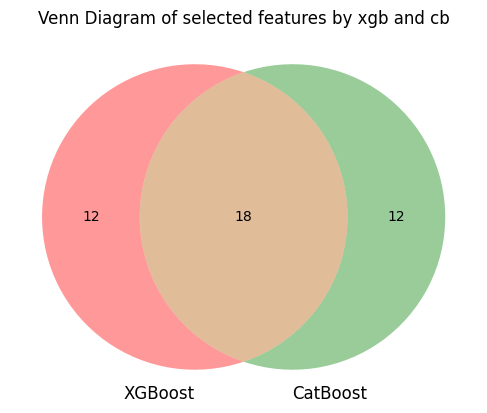

In [5]:
## Intersect selected features

selected_features_xgb = ['monthly_average_price', 'year', 'quarter', 'around_Xmas', 'month_sin', 'month_cos', 'item_id_y_sum_lag1', 'item_id_y_max_lag1', 'item_id_y_max_lag2', 'item_id_city_id_y_sum_lag1', 'item_id_city_id_y_max_lag1', 'item_id_city_id_y_min_lag1', 'item_id_city_id_y_min_lag2', 'shop_id_item_category_id_y_max_lag1', 'shop_id_item_category_id_y_min_lag1', 'item_category_id_year_monthly_average_price_max', 'item_category_id_year_monthly_average_price_min', 'item_id_quarter_monthly_average_price_mean', 'item_category_id_quarter_revenue_mean', 'item_category_id_quarter_revenue_std', 'item_id_month_revenue_mean', 'item_category_id_month_revenue_mean', 'city_id_month_revenue_mean', 'ytd_sales', 'quarterly_sales', 'price_change', 'lag1', 'lag2', 'rolling_mean_lag1_window_size2', 'rolling_mean_lag2_window_size2']
selected_features_cb = ['monthly_average_price', 'year', 'quarter', 'around_Xmas', 'month_sin', 'month_cos', 'item_id_y_sum_lag2', 'item_id_y_max_lag1', 'item_category_id_y_max_lag1', 'item_id_city_id_y_max_lag1', 'item_category_id_revenue_max_lag2', 'item_id_city_id_revenue_min_lag1', 'item_category_id_city_id_revenue_sum_lag2', 'city_id_revenue_sum_lag1', 'city_id_revenue_sum_lag2', 'shop_id_year_monthly_average_price_std', 'item_category_id_year_monthly_average_price_mean', 'item_category_id_year_revenue_mean', 'item_id_quarter_revenue_max', 'item_id_around_Xmas_revenue_mean', 'item_id_month_revenue_mean', 'item_category_id_month_revenue_mean', 'city_id_month_revenue_mean', 'ytd_sales', 'quarterly_sales', 'price_change', 'lag1', 'lag2', 'rolling_mean_lag1_window_size2', 'rolling_mean_lag2_window_size2']

set1 = set(selected_features_xgb)
set2 = set(selected_features_cb)

# Create the Venn Diagram
venn2(subsets = [set1, set2], set_labels = ('XGBoost', 'CatBoost'))
plt.title("Venn Diagram of selected features by xgb and cb")
plt.show()

## With validation set

In [ ]:
""" train = train.set_index(['ds', 'unique_id']).dropna()
valid = valid.set_index(['ds', 'unique_id']).dropna()

X_train, X_val = train.drop('y', axis=1), valid.drop('y', axis=1)
y_train, y_val = train['y'], valid['y']

# Initialize variables for feature selection
best_rmse = float('inf')
best_features = []
n_features_range = range(1, 101)

# Perform Recursive Feature Elimination with cross-validation
for n_features in n_features_range:
    
    # Perform RFE
    rfe = RFE(estimator=tunned_xgb, n_features_to_select=n_features)
    rfe = rfe.fit(X_train, y_train)

    # Get selected features
    selected_features = X_train.columns[rfe.support_].tolist()

    # Train tunned_xgb with selected features
    X_train_selected = X_train[:, rfe.support_]
    X_val_selected = X_val[:, rfe.support_]

    tunned_xgb.fit(X_train_selected, y_train)

    # Make predictions on validation set
    y_pred = tunned_xgb.predict(X_val_selected)

    # Calculate RMSE
    rmse = sqrt(mean_squared_error(y_val, y_pred))

    # Update best features if RMSE improves
    if rmse < best_rmse:
        best_rmse = rmse
        best_features = selected_features

print(f"Best RMSE: {best_rmse}")
print("Optimal features:")
print(best_features) """

' \n# Assuming fcst is imported and train, valid are defined\n\n# Preprocess and combine data\nfull_train = fcst.preprocess(pd.concat([train, valid]))\nfull_train = full_train.set_index([\'ds\', \'unique_id\']).dropna()\n\n# Split into features and target\nX = full_train.drop(\'y\', axis=1)\ny = full_train[\'y\']\n\n# Split data into train and validation sets\ntrain_size = len(train) / (len(train) + len(valid))\ntrain_index = int(len(full_train) * train_size)\n\nX_train, X_val = X[:train_index], X[train_index:]\ny_train, y_val = y[:train_index], y[train_index:]\n\n# Scale features\nscaler = StandardScaler()\nX_train_scaled = scaler.fit_transform(X_train)\nX_val_scaled = scaler.transform(X_val)\n\n# Initialize variables for feature selection\nbest_rmse = float(\'inf\')\nbest_features = []\nn_features_range = range(1, len(X.columns) + 1)\n\n# Perform Recursive Feature Elimination with cross-validation\nfor n_features in n_features_range:\n    # Create XGBoost model\n    model = XGBRegres

# Test XGBoost with selected features

## Train, val, test selected

In [36]:
train_valid_columns = [col for col in selected_features_xgb if col in train.columns] + ['y', 'ds', 'unique_id']
train_selected = train[train_valid_columns]
valid_selected = valid[train_valid_columns]
test_selected = test[train_valid_columns]

In [22]:
future_df = pd.concat([train_selected, valid_selected]).drop('y', axis=1)

In [23]:
print(train_selected.shape)
print(valid_selected.shape)

print(future_df.shape)

(12354, 33)
(426, 33)
(12780, 32)


In [27]:
@njit
def diff(x, lag):
    x2 = np.full_like(x, np.nan)
    for i in range(lag, len(x)):
        x2[i] = x[i] - x[i-lag]
    return x2

sk_log1p = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)

fcst = MLForecast(
    models=tunned_models,
    freq='M',
    num_threads=6
)

In [29]:
fcst.fit(train_selected, fitted=True, id_col='unique_id', time_col='ds', 
         target_col='y', static_features=[])

MLForecast(models=[XGBRegressor, CatBoostRegressor], freq=M, lag_features=[], date_features=[], num_threads=6)

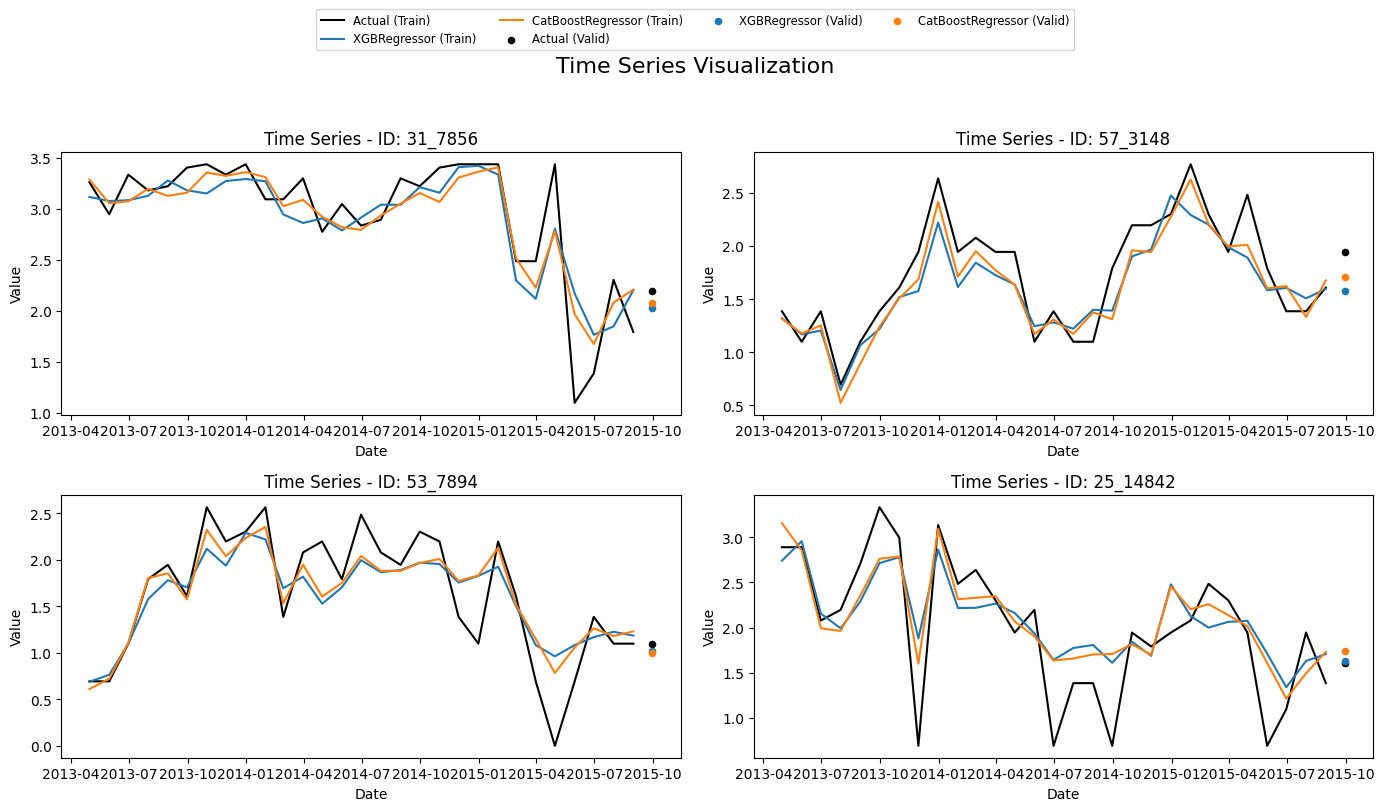

MEAN RMSE_VALID = 0.4012632287198834

Model with lowest RMSE validation is CatBoostRegressor with RMSE = 0.4011871418278789

                   RMSE_train  R2_train  RMSE_valid  R2_valid
CatBoostRegressor    0.287406  0.883131    0.401187  0.730297
XGBRegressor         0.332806  0.843292    0.401339  0.730092


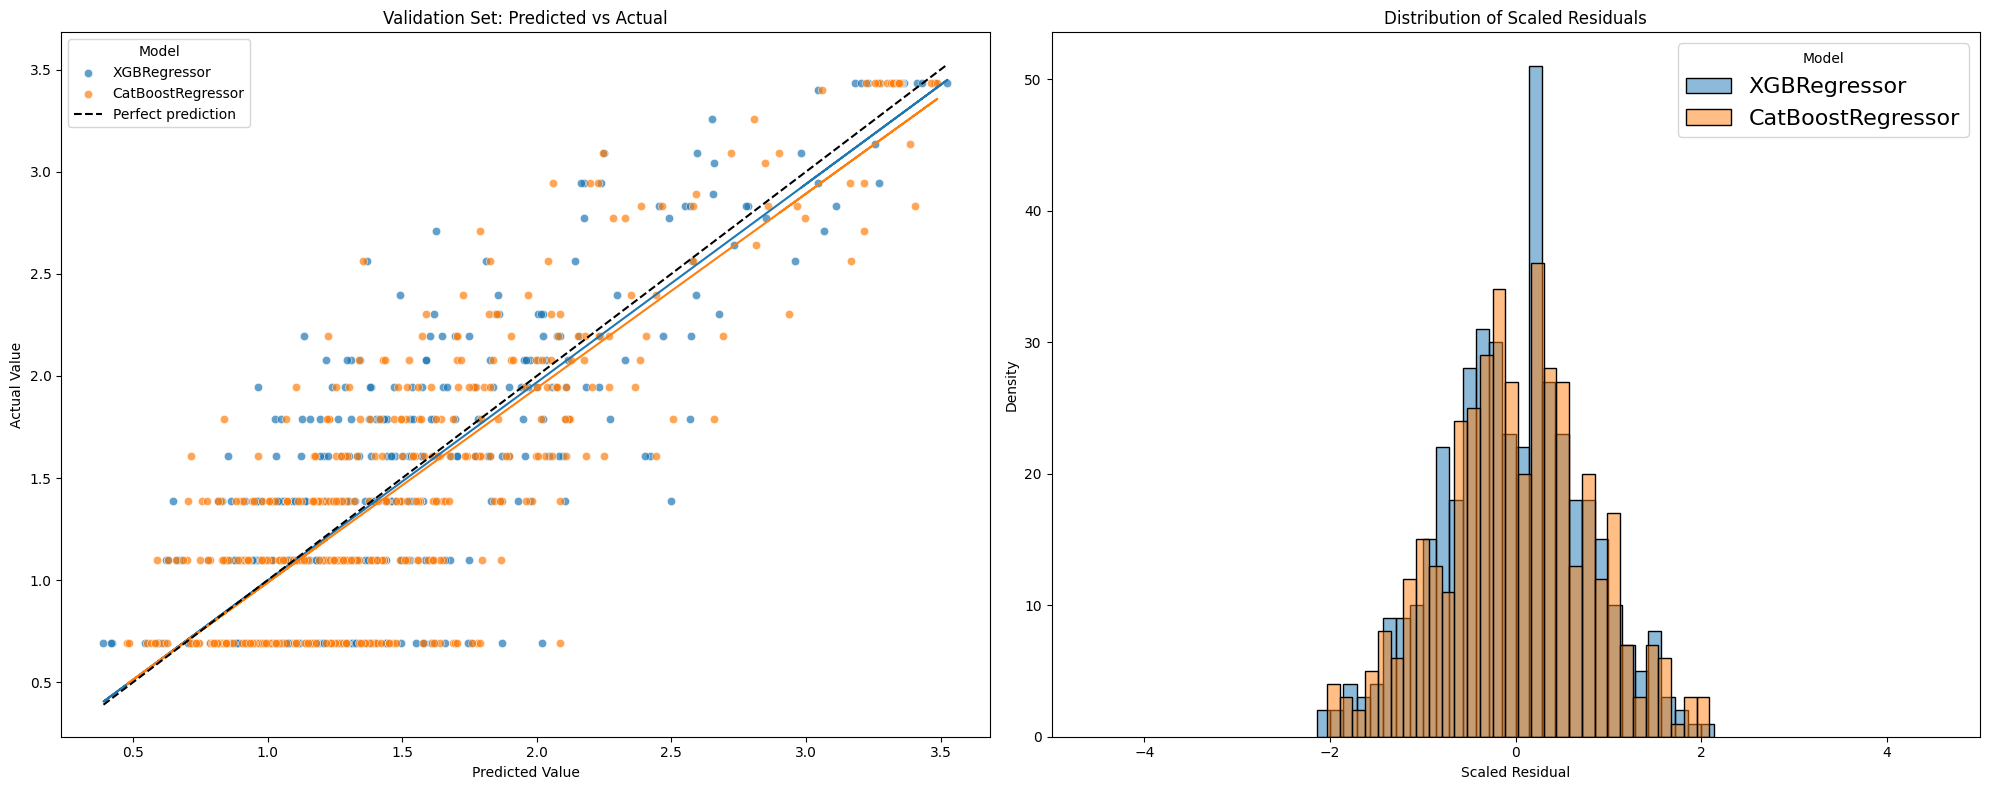

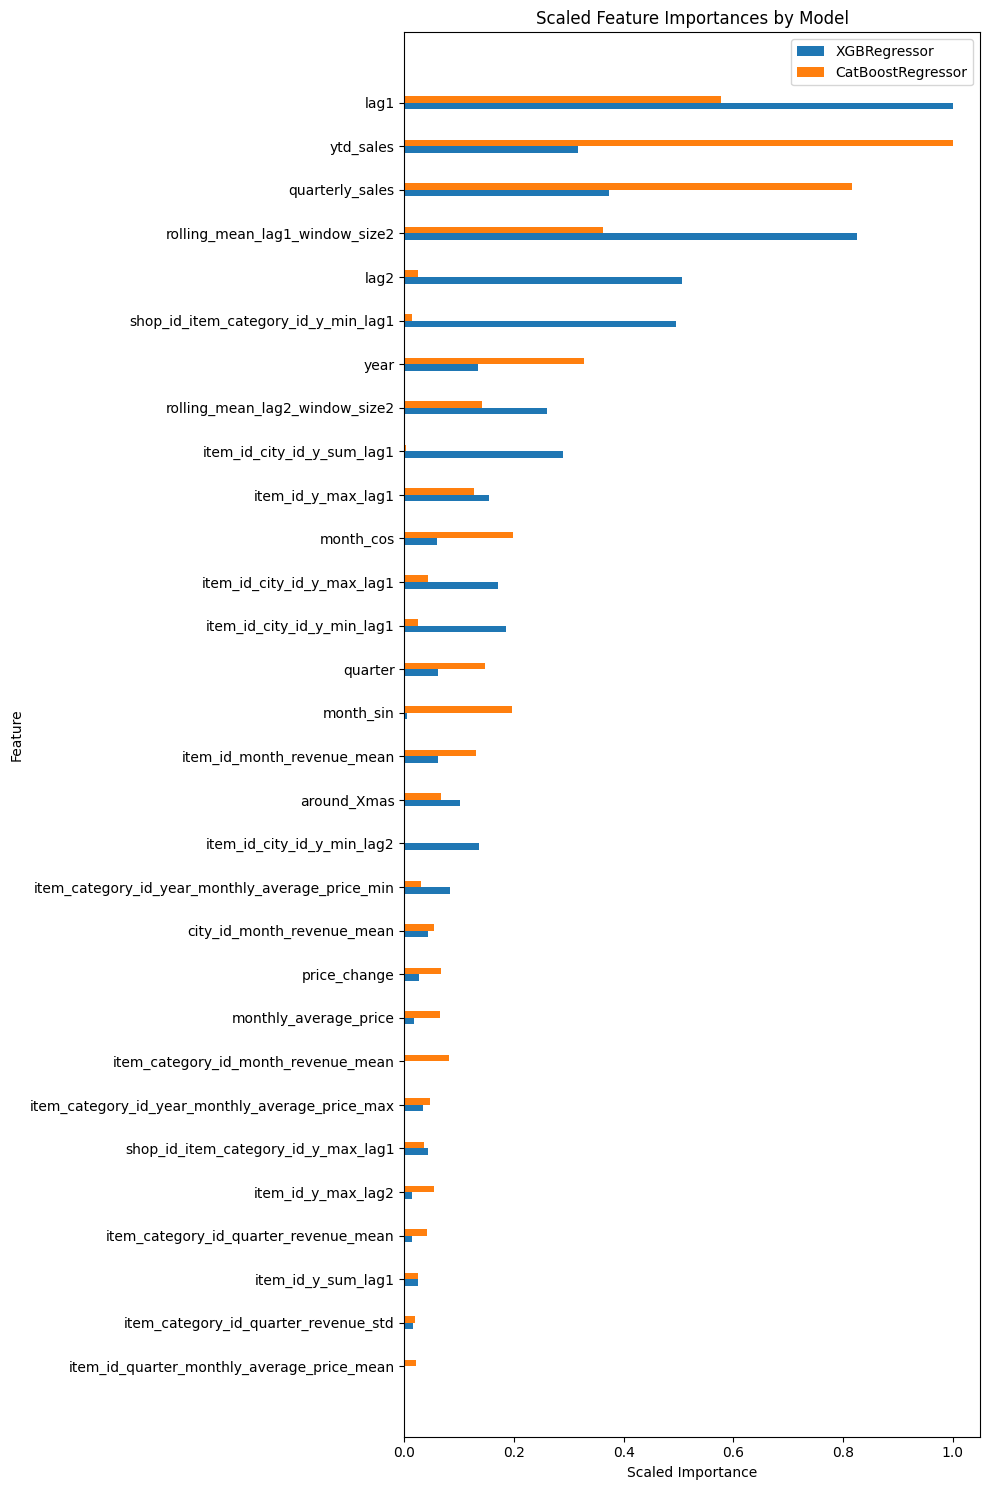

In [30]:
# Assuming you have your fcst object and valid set ready
evaluator = MLForecast_Evaluator(fcst, valid_selected, future_df, h=1)

# Plot time series
evaluator.plot_time_series(n_samples=4)  # Will show 4 random time series in a 2x2 grid

# Calculate and print metrics
evaluator.calculate_metrics()

# Plot metrics
evaluator.plot_metrics()

# Plot feature importances sorted by the average importance
evaluator.plot_feature_importances()

# Predicting future values (test) with train+valid fit

In [40]:
full_train = pd.concat([train_selected, valid_selected])
future_df2 = test_selected.drop('y', axis=1)

In [41]:
fcst.fit(full_train, fitted=True, id_col='unique_id', time_col='ds', 
         target_col='y', static_features=[])

MLForecast(models=[XGBRegressor, CatBoostRegressor], freq=M, lag_features=[], date_features=[], num_threads=6)

In [43]:
np.expm1(0.4)

0.49182469764127035

In [46]:
evaluator_test.predictions['XGBRegressor'].apply(lambda x: np.expm1(x))

0      14.523080
1      24.622837
2      29.132796
3      28.804326
4       2.333480
         ...    
421     5.739323
422     2.163548
423     3.301038
424     2.622172
425     3.028421
Name: XGBRegressor, Length: 426, dtype: float64

In [42]:
# Predict h=2 and save second prediction as submission
evaluator_test = MLForecast_Evaluator(fcst, valid, future_df2, h=1)
#evaluator.calculate_metrics()

#for model in evaluator.model_columns:
model = 'XGBRegressor'
evaluator_test.predict_save_submission(model, test_index=test_index)

Submission file 'submissions\2024-07-18_submission_XGBRegressor_mean_valid_RMSE_unknown.csv' has been created successfully.


,unique_id,monthly_sales
0,12_11365,2.742328
1,12_11369,3.243484
2,12_11370,3.405614
3,12_11373,3.394654
4,12_12231,1.204017
...,...,...
421,7_5822,1.907959
422,7_6185,1.151694
423,7_6497,1.458856
424,7_7856,1.287074


### Save manual imputed predictiosn for low var ids:

In [ ]:
test_preds = evaluator_test.predict_save_submission(model, test_index=test_index)
test_preds

Submission file 'submissions\2024-07-17_submission_XGBRegressor_mean_valid_RMSE_unknown.csv' has been created successfully.


,unique_id,monthly_sales
0,12_11365,14.738902
1,12_11369,24.659309
2,12_11370,26.023418
3,12_11373,26.571476
4,12_12231,3.018536
...,...,...
421,7_5822,6.689595
422,7_6185,2.736765
423,7_6497,3.949050
424,7_7856,2.526999


In [ ]:
n=0
low_var_ids = []
for uniqueid in full_train['unique_id'].unique():
    if full_train[full_train['unique_id'] == uniqueid]['y'].tail(24).std() < 1.5:
        n += 1
        low_var_ids.append(uniqueid)
        print(uniqueid,n)

12_11370 1
12_11373 2
14_20949 3
16_20949 4
19_1523 5
21_13881 6
22_19331 7
22_20949 8
28_16210 9
28_20949 10
28_5324 11
28_7220 12
31_10158 13
31_10334 14
31_1201 15
31_12064 16
31_12558 17
31_17811 18
31_18672 19
31_21445 20
31_2607 21
31_3656 22
31_9507 23
35_20949 24
35_2252 25
37_6185 26
42_12134 27
42_13881 28
46_20949 29
47_5643 30
50_20949 31
52_16209 32
52_2252 33
52_7856 34
53_13881 35
53_20949 36
55_492 37
56_20949 38
57_3158 39
59_2252 40
5_20949 41
6_5643 42
7_20949 43


In [ ]:
for id in low_var_ids:
    test_preds.loc[test_preds['unique_id'] == id, 'monthly_sales'] = full_train[full_train['unique_id'] == id]['y'].tail(24).mean()

test_preds.to_csv(f'./submissions/manual_imputed_preds_std1.5.csv', index=False)